## MNIST Denoising Autoencoder
based on Keras.io example [here.](https://keras.io/examples/mnist_denoising_autoencoder/)  
F. Burkholder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

[Activation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) - applies an activation to an output.  Available [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations) in TF 2.0.  
[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) - a fully connected dense layer of neurons.  
[Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) - makes a Keras tensor (shape, batch_size) for handling inputs during training.  
[Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) - a 2D convolutional layer.  Performs spatial convolution over images.  
[Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) - makes a 1D vector out of whatever input comes in.  For the autoencoder, this makes our lower dimensional coding, or latent representation.  
[Reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) - reshapes an output to a given shape.  Bookkeeping.  
[Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) - Transposed convolution layer (sometimes called Deconvolution).  
[Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) - groups layers into an object with training and inference (prediction) features.  
[backend](https://www.tensorflow.org/api_docs/python/tf/keras/backend) - useful functions.  
[MNIST](https://en.wikipedia.org/wiki/MNIST_database) - Classic dataset of handwritten numbers, 0-9.

In [3]:
np.random.seed(1) # get consistent results from a stochastic training process

### MNIST dataset - read in and preprocessing

In [4]:
# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [6]:
def plot_image_and_histogram(img):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Image')
    ax2 = fig.add_subplot(122)
    ax2.hist(img.flatten(), color='gray', bins=25)
    ax2.set_title('Histogram of pixel intensities')
    ax2.set_xlabel('Pixel intensity')
    ax2.set_ylabel('Count')
    plt.tight_layout(pad=1)

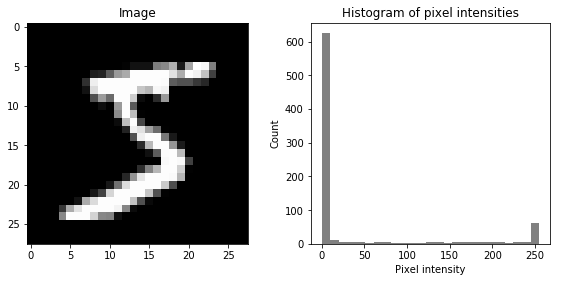

In [7]:
plot_image_and_histogram(x_train[0])

In [8]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


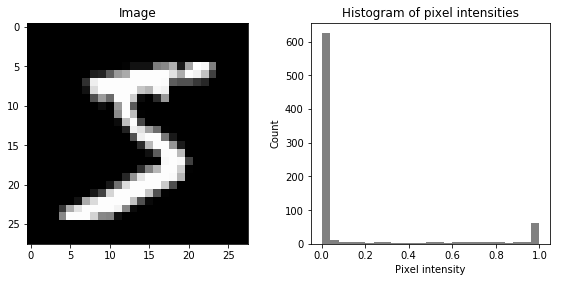

In [10]:
plot_image_and_histogram(x_train[0].reshape(28,28))

### Add noise to data (to be later denoised)

In [11]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

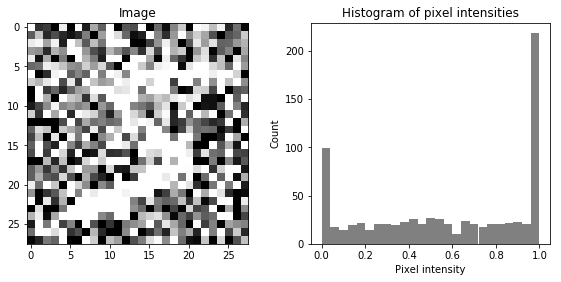

In [12]:
plot_image_and_histogram(x_train_noisy[0].reshape(28,28))

### Network parameters

In [13]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16 # our coding
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [16, 32]

### Build the autoencoder

#### The encoder  
Uses the [Keras Functional API.](https://www.tensorflow.org/guide/keras/functional)  <br> It's more flexible than Sequential.  The architecture below could have been coded in the Sequential API too.

In [14]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [15]:
# Shape info needed to build Decoder Model
shape = K.int_shape(x)

In [16]:
# Generate the latent vector - latent is our encoded representation of the image
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [17]:
# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                25104     
Total params: 29,904
Trainable params: 29,904
Non-trainable params: 0
_________________________________________________________________


#### The decoder

In [18]:
shape

(None, 7, 7, 32)

In [19]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [20]:
# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

In [21]:
x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

In [22]:
# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 1568)              26656     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0   

### Autoencoder = Encoder + Decoder

In [23]:
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                29904     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         40673     
Total params: 70,577
Trainable params: 70,577
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder.compile(loss='mse', optimizer='adam')

### Train the autoencoder

In [25]:
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 33s 544us/sample - loss: 0.0678 - val_loss: 0.0376
Epoch 2/10
60000/60000 [==============================] - 33s 545us/sample - loss: 0.0304 - val_loss: 0.0263
Epoch 3/10
60000/60000 [==============================] - 32s 537us/sample - loss: 0.0253 - val_loss: 0.0235
Epoch 4/10
60000/60000 [==============================] - 26s 430us/sample - loss: 0.0230 - val_loss: 0.0217
Epoch 5/10
60000/60000 [==============================] - 29s 484us/sample - loss: 0.0214 - val_loss: 0.0205
Epoch 6/10
60000/60000 [==============================] - 23s 382us/sample - loss: 0.0202 - val_loss: 0.0197
Epoch 7/10
60000/60000 [==============================] - 21s 351us/sample - loss: 0.0195 - val_loss: 0.0191
Epoch 8/10
60000/60000 [==============================] - 29s 479us/sample - loss: 0.0190 - val_loss: 0.0187
Epoch 9/10
60000/60000 [==============================] - 23s 380us/sample - l

### Predictions

In [26]:
x_decoded = autoencoder.predict(x_test_noisy)

### Display results

In [27]:
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

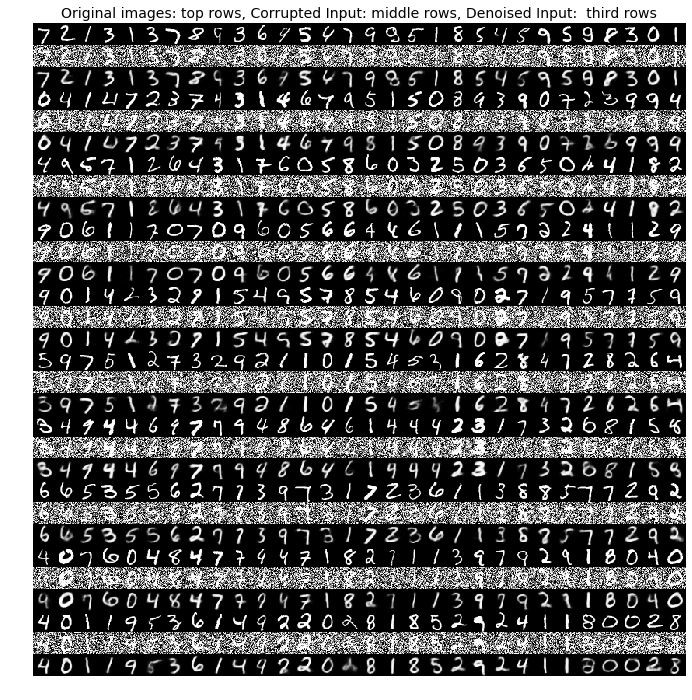

In [28]:
plt.figure(figsize=(12,12))
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows', fontsize=14)
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()